In [2]:
cd ~/Umila/numila

/Users/fred/Umila/numila


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotting

import main
import utils

/Users/fred/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


## Setup

We first train the model on two corpora generated by PCFGS. The two PCFGs are identical except for one `DET` and one `NOUN`. The first has "that" and "table", while the second has "my" and "bunny". Importantly, _the model never sees "my table" or "that bunny"_. Thus, if the model is just tracking statistics between individual words (or chunks), then we expect "that table" to have a chunkability of 0 because the model has never seen this chunk. If the model is able to generalize, however, it will (1) capture the similarity of "table" to the other nouns, (2) notice that these other nouns have occurred with "table", and (3) use this information to assign a non-zero chunkability to "that table".

In [19]:
# Train the model.
import pcfg
toy_pcfg = '''
S    -> NP VP [1.0]
VP   -> V NP [0.5]
VP   -> V [0.5]
NP   -> Det N [0.7]
NP   -> Name [0.3]
V    -> 'saw' [0.5]
V    -> 'ate' [0.5]
N    -> 'boy' [0.5]
N    -> '{NOUN}' [0.50]
Name -> 'Jack' [0.5]
Name -> 'Bob' [0.5]
Det  -> 'the' [0.5]
Det  -> '{DET}' [0.5]
'''

that_table_pcfg = toy_pcfg.format(DET='that', NOUN='table')
my_bunny_pcfg = toy_pcfg.format(DET='my', NOUN='bunny')


models = [main.Numila(GENERALIZE=g) for g in [0.0, 0.1]]
combined_corpus = utils.flatten(zip(pcfg.random_sentences(that_table_pcfg, 200),
                                    pcfg.random_sentences(my_bunny_pcfg, 200)))
for s in combined_corpus:
    for model in models:
        model.parse_utterance(s)

In [25]:
# Check how many times each critical pair occured.

model = models[0]  # will be the same for all models

def print_counts(w1, w2):
    print('{:4} -> {}: {}'.format(
          w1, w2, model.graph._edge_counts['ftp'][w1][w2]))

print_counts('that', 'table')
print_counts('that', 'bunny')
print_counts('my', 'table')
print_counts('my', 'bunny')

that -> table: 84
that -> bunny: 0
my   -> table: 0
my   -> bunny: 102


## Results

In its current form, the model is able to generalize somewhat, but not especially well.

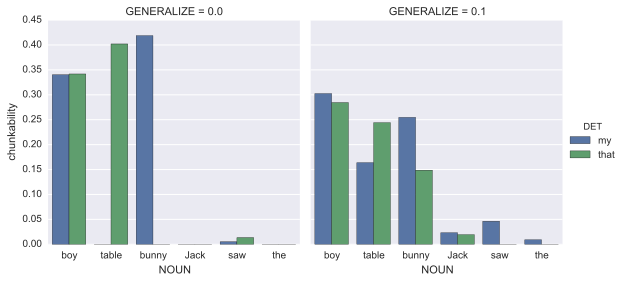

In [24]:
# Test chunkabilities.

data = [(model.params['GENERALIZE'], det, noun,
         model.chunkability(model.graph[det], model.graph[noun]))
        for model in models
        for det in ['my', 'that']
        for noun in ['boy', 'table', 'bunny', 'Jack', 'saw', 'the']]

df = pd.DataFrame(data, columns=['GENERALIZE', 'DET', 'NOUN', 'chunkability'])
sns.factorplot('NOUN', 'chunkability', col='GENERALIZE', hue='DET', data=df, kind='bar')

As expected, `[my table]` and `[that bunny]` have 0 chunkability when generalization is 0. This is because these words never occur adjacently in the training data. When we apply generalization, however, the model assigns a considerable chunkability to these pairs that it has never seen.

Additionally, although there is some over-generalization, it appears to be limited in this case. We see some over-generalization because noun phrases and verbs have somewhat similar distribution (e.g. all can be followed by an utterance boundary. Further testing is needed to determine if over-generalization of this sort will become a significant problem.